<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%205/Case_Study_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!pip install scikit-learn-intelex

In [100]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from numpy import arange
from sklearn.model_selection import GridSearchCV
import time

#from example SVM notebook
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import SGDClassifier

Prediction on the Action column, for use with a firewall.

Port is like an address that allows connection like a tv channel.


In [101]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%205/log2.csv")
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [103]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


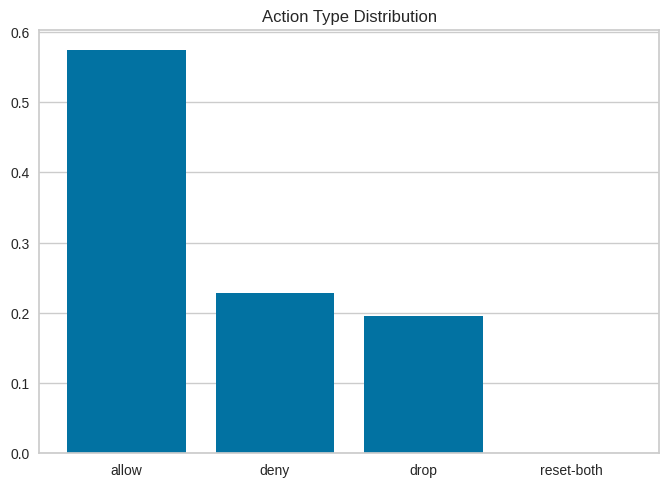

In [104]:
plt.bar(df['Action'].value_counts(normalize=True).index,df['Action'].value_counts(normalize=True))
plt.grid(axis='x')
plt.title('Action Type Distribution')
plt.show()

In [105]:
df['Source Port'] = df['Source Port'].astype(str)
df['Destination Port'] = df['Destination Port'].astype(str)
df['NAT Source Port'] = df['NAT Source Port'].astype(str)
df['NAT Destination Port'] = df['NAT Destination Port'].astype(str)

In [106]:
df.describe()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [107]:
value_counts = df['Source Port'].value_counts()
value_counts

58638    840
27005    513
443      273
57470    222
49418    210
        ... 
32996      1
60574      1
60570      1
65368      1
54871      1
Name: Source Port, Length: 22724, dtype: int64

In [108]:
sp_agg = df.groupby(['Source Port']).size().reset_index(name='counts')
sp_agg

,Source Port,counts
0,0,173
1,10000,3
2,10001,2
3,10002,2
4,10003,8
...,...,...
22719,993,19
22720,9957,3
22721,9968,1
22722,9969,1


In [109]:
sp_counts = sp_agg.groupby(['counts']).size().reset_index(name='Number_of_counts')
sp_counts

,counts,Number_of_counts
0,1,9102
1,2,4456
2,3,3481
3,4,1932
4,5,1282
5,6,916
6,7,581
7,8,337
8,9,234
9,10,144


In [110]:
dp_agg = df.groupby(['Destination Port']).size().reset_index(name='counts')
dp_agg

,Destination Port,counts
0,0,173
1,1,85
2,10004,2
3,10010,9
4,10012,2
...,...,...
3268,993,40
3269,995,10
3270,9986,7
3271,9992,1


In [111]:
value_counts = df['Source Port'].value_counts()

#creating list of columns with fewer than 32 values to remove before turning into categorical column (equals .05% of the rows in this dataset)
droplist = pd.DataFrame(value_counts)
droplist = droplist[droplist['Source Port']< 32]
droplist = list(droplist.index.values)

value_counts_DP = df['Destination Port'].value_counts()

#creating list of columns with fewer than 32 values to remove before turning into categorical column (equals .05% of the rows in this dataset)
droplist_DP = pd.DataFrame(value_counts_DP)
droplist_DP = droplist_DP[droplist_DP['Destination Port']< 32]
droplist_DP = list(droplist_DP.index.values)

value_counts_NAT = df['NAT Source Port'].value_counts()
droplist_NAT = pd.DataFrame(value_counts_NAT)
droplist_NAT = droplist_NAT[droplist_NAT['NAT Source Port']< 32]
droplist_NAT = list(droplist_NAT.index.values)

value_counts_NAT_DP = df['NAT Destination Port'].value_counts()
droplist_NAT_DP = pd.DataFrame(value_counts_NAT_DP)
droplist_NAT_DP = droplist_NAT_DP[droplist_NAT_DP['NAT Destination Port']<32]
droplist_NAT_DP = list(droplist_NAT_DP.index.values)

In [112]:
len(droplist)

22691

In [113]:
len(droplist_DP)

3196

In [114]:
len(droplist_NAT)

29149

In [115]:
len(droplist_NAT_DP)

2510

There are 22,724 distinct Source Ports in this dataset.

In [116]:
#i=0

#Replacing low frequency Source Ports (under .05%), with "low-frequency" value, to limit the size of the dataframe

#while i < len(droplist):
#  df['Source Port']=df['Source Port'].replace((droplist[i]),"low-frequency")
#  print(droplist[i])
#  i+=1

# runs a bit faster
sp_list = []
for i in df.index:
    if df['Source Port'][i] in droplist:
        sp_list.append('low-frequency')
    else:
        sp_list.append(df['Source Port'][i])
df['Source Port']=sp_list

In [117]:
#i=0

#Replacing low frequency Source Ports (under .05%), with "Dropped" value, to limit the size of the dataframe

#while i < len(droplist_DP):
#  df['Destination Port']=df['Destination Port'].replace((droplist_DP[i]),"low-frequency")
#  print(droplist_DP[i])
#  i+=1

# runs a bit faster
dp_list = []
for i in df.index:
    if df['Destination Port'][i] in droplist_DP:
        dp_list.append('low-frequency')
    else:
        dp_list.append(df['Destination Port'][i])
df['Destination Port'] = dp_list

In [118]:
nat_list = []
for i in df.index:
    if df['NAT Source Port'][i] in droplist_NAT:
        nat_list.append('low-frequency')
    else:
        nat_list.append(df['NAT Source Port'][i])
df['NAT Source Port'] = nat_list

In [119]:
nat_dp_list = []
for i in df.index:
    if df['NAT Destination Port'][i] in droplist_NAT_DP:
        nat_dp_list.append('low-frequency')
    else:
        nat_dp_list.append(df['NAT Destination Port'][i])
df['NAT Destination Port'] = nat_dp_list

In [120]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'Action']

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list((set(cols) - set(num_cols)))

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns,sparse=True)

#creating dataframe of numeric columns
scaler = StandardScaler()
num_df = scaler.fit_transform(X[num_cols])

X=cat_df.join(pd.DataFrame(num_df,columns=X[num_cols].columns, index=X[num_cols].index))
X

,Destination Port_0,Destination Port_1,Destination Port_11392,Destination Port_123,Destination Port_1433,Destination Port_15000,Destination Port_15503,Destination Port_161,Destination Port_17372,Destination Port_21247,...,NAT Source Port_48817,NAT Source Port_58638,NAT Source Port_low-frequency,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,-0.010376,-0.024498
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,-0.008823,-0.019550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,-0.011619,-0.026747
65528,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.815823,0.011736,1.842607,0.890740,0.036919,0.293149,1.632037
65529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646
65530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646


Updates for Source & Destination Port, changed column number from 57,689 down to 31,805 by replacing values which represented less than 99.95% of the data overall (to help make the model more efficient, since that is a requirement for this model to be leveraged).

In [121]:
import scipy.sparse

X = scipy.sparse.coo_matrix(X)
X.shape

(65532, 147)

In [122]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['Action']].values.flatten()
#y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

In [124]:
y_alt

array(['allow', 'allow', 'allow', ..., 'drop', 'drop', 'drop'],
      dtype=object)

In [125]:
#linear svc
model = LinearSVC(max_iter=100000,tol=0.01,random_state=709)
X_train,X_test, y_train,y_test = train_test_split(X,y_alt)
C_list = [.001,.005,.01,.05,.1,.2,.5,.8,1,3,5,10,20,50,100,500,1000,5000,10000,100000]

In [ ]:
train_lsvc = pd.DataFrame()
for C in C_list:
    model.C = C
    model.fit(X_train,y_train)
    p=model.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[C])
    train_lsvc = pd.concat([train_lsvc,df_search])
train_lsvc

In [126]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
# kernel linear
model_svc_l = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='linear')
train_svc_l = pd.DataFrame()
for C in C_list:
    model_svc_l.C = C
    model_svc_l.fit(X_train,y_train)
    p=model_svc_l.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]}, index=[C])
    train_svc_l = pd.concat([train_svc_l,df_search])
train_svc_l

,accuracy
0.001,0.944394
0.005,0.953305
0.010,0.953366
0.050,0.957822
0.100,0.957822
0.200,0.958127
0.500,0.958860
0.800,0.958921
1.000,0.958921
3.000,0.960081


In [ ]:
#kernel rbf
model_svc_r = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='rbf')
train_svc_r = pd.DataFrame()
for C in C_list:
    model_svc_r.C = C
    model_svc_r.fit(X_train,y_train)
    p=model_svc_r.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]}, index=[C])
    train_svc_r = pd.concat([train_svc_r,df_search])
train_svc_r

,accuracy
0.001,0.944394
0.005,0.944394
0.010,0.944394
0.050,0.953366
0.100,0.957822
0.200,0.957822
0.500,0.957822
0.800,0.957822
1.000,0.957822
3.000,0.958677


In [ ]:
#kernel sigmoid
model_svc_s = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='sigmoid')
train_svc_s = pd.DataFrame()
for C in C_list:
    model_svc_s.C = C
    model_svc_s.fit(X_train,y_train)
    p=model_svc_s.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]}, index=[C])
    train_svc_s = pd.concat([train_svc_s,df_search])
train_svc_s

,accuracy
0.001,0.990051
0.005,0.944394
0.010,0.944394
0.050,0.947812
0.100,0.953366
0.200,0.957822
0.500,0.957822
0.800,0.957822
1.000,0.957822
3.000,0.958127


In [ ]:
train_lsvc.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
100000.0,0.997436
5000.0,0.997436
10000.0,0.997009


In [ ]:
train_svc_l.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
100000.0,0.962644
10000.0,0.961729
5000.0,0.961729


In [ ]:
train_svc_r.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
100000.0,0.961912
10000.0,0.961729
5000.0,0.961607


In [ ]:
train_svc_s.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
0.001,0.990051
100000.000,0.961668
10000.000,0.961607


In [127]:
model_lin = LinearSVC(max_iter=100000,tol=0.01,random_state=709,C = 20000)
model_lin.fit(X_train,y_train)
start = time.time()
p_linSVC = model_lin.predict(X_test)
stop = time.time()
linsvc_rep = classification_report(y_test,p_linSVC,output_dict=True)
lsvcTime = stop-start

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [128]:
model_svc_lin = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='linear',C=100000)
model_svc_lin.fit(X_train,y_train)
start = time.time()
p_SVClin = model_svc_lin.predict(X_test)
stop=time.time()
svc_lin_rep = classification_report(y_test,p_SVClin,output_dict=True)
svc_linTime = stop-start

In [129]:
model_svc_rbf = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='rbf',C=100000)
model_svc_rbf.fit(X_train,y_train)
start = time.time()
p_SVCrbf = model_svc_rbf.predict(X_test)
stop=time.time()
svc_rbf_rep = classification_report(y_test,p_SVCrbf,output_dict=True)
svc_rbfTime = stop-start

In [130]:
model_svc_sig = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='sigmoid',C=.001)
model_svc_sig.fit(X_train,y_train)
start = time.time()
p_SVCsig = model_svc_sig.predict(X_test)
stop=time.time()
svc_sig_rep = classification_report(y_test,p_SVCsig,output_dict=True)
svc_sigTime = stop-start

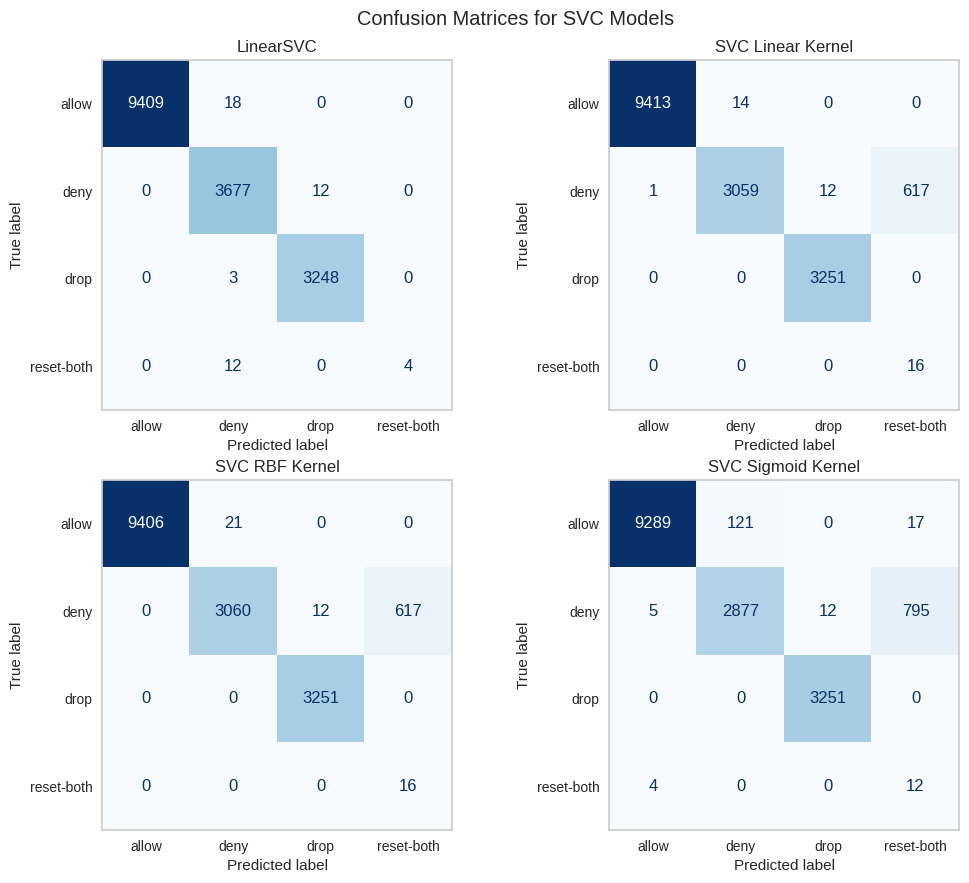

In [131]:
fig, ax = plt.subplots(2,2,figsize = (12,10))
disp_1 = ConfusionMatrixDisplay.from_predictions(y_test,p_linSVC,ax=ax[0][0],colorbar=False,cmap='Blues')
disp_2 = ConfusionMatrixDisplay.from_predictions(y_test,p_SVClin,ax=ax[0][1],colorbar=False,cmap='Blues')
disp_3 = ConfusionMatrixDisplay.from_predictions(y_test,p_SVCrbf,ax=ax[1][0],colorbar=False,cmap = 'Blues')
disp_4 = ConfusionMatrixDisplay.from_predictions(y_test,p_SVCsig,ax=ax[1][1],colorbar=False,cmap = 'Blues')
ax[0][0].grid(False)
ax[0][0].set_title('LinearSVC',fontsize=12)
ax[0][1].grid(False)
ax[0][1].set_title('SVC Linear Kernel',fontsize=12)
ax[1][0].grid(False)
ax[1][0].set_title('SVC RBF Kernel',fontsize=12)
ax[1][1].grid(False)
ax[1][1].set_title('SVC Sigmoid Kernel',fontsize=12)
plt.suptitle('Confusion Matrices for SVC Models',y=.93)
plt.show()

In [133]:
a_list = [0.0001, 0.0005, .001,.005,.01,.05,.1,.2,.5,.8,1,5,10,50,100,500,1000,5000,10000,100000]

In [134]:
#sgd with hinge
from sklearn.linear_model import SGDClassifier
sgd_hin = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='hinge')
train_sgd_hin = pd.DataFrame()
for a in a_list:
    sgd_hin.alpha = a
    sgd_hin.fit(X_train,y_train)
    p = sgd_hin.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[a])
    train_sgd_hin = pd.concat([train_sgd_hin,df_search])
train_sgd_hin

,accuracy
0.0001,0.949155
0.0005,0.955686
0.0010,0.957456
0.0050,0.949582
0.0100,0.987426
0.0500,0.987792
0.1000,0.988769
0.2000,0.988769
0.5000,0.988769
0.8000,0.988769


In [136]:
#sgd with log-loss
from sklearn.linear_model import SGDClassifier
sgd_log = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='log_loss')
train_sgd_log = pd.DataFrame()
for a in a_list:
    sgd_log.alpha = a
    sgd_log.fit(X_train,y_train)
    p = sgd_log.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[a])
    train_sgd_log = pd.concat([train_sgd_log,df_search])
train_sgd_log

,accuracy
0.0001,0.955686
0.0005,0.987792
0.0010,0.987792
0.0050,0.988769
0.0100,0.988769
0.0500,0.988769
0.1000,0.988769
0.2000,0.988769
0.5000,0.988769
0.8000,0.988769


In [138]:
#sgd with modified huber
from sklearn.linear_model import SGDClassifier
sgd_hub = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='modified_huber')
train_sgd_hub = pd.DataFrame()
for a in a_list:
    sgd_hub.alpha = a
    sgd_hub.fit(X_train,y_train)
    p = sgd_hub.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[a])
    train_sgd_hub = pd.concat([train_sgd_hub,df_search])
train_sgd_hub

,accuracy
0.0001,0.957578
0.0005,0.956968
0.0010,0.955625
0.0050,0.990905
0.0100,0.987426
0.0500,0.988769
0.1000,0.988769
0.2000,0.988769
0.5000,0.988769
0.8000,0.988769


In [135]:
train_sgd_hin.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
50.0,0.993042
100.0,0.992981
10.0,0.989562


In [137]:
train_sgd_log.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
50.0,0.993042
100.0,0.992981
10.0,0.989562


In [139]:
train_sgd_hub.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
100.000,0.992981
0.005,0.990905
10.000,0.989562


In [ ]:
model.C = 0.005
model.fit(X_train,y_train)
p=model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,p))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       allow       1.00      0.99      1.00      9429
        deny       0.98      0.99      0.99      3654
        drop       1.00      1.00      1.00      3284
  reset-both       0.00      0.00      0.00        16

    accuracy                           0.99     16383
   macro avg       0.74      0.75      0.75     16383
weighted avg       0.99      0.99      0.99     16383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X.columns

Index(['NAT Source Port_0', 'NAT Source Port_10000', 'NAT Source Port_10001',
       'NAT Source Port_10002', 'NAT Source Port_10005',
       'NAT Source Port_10007', 'NAT Source Port_10010',
       'NAT Source Port_10011', 'NAT Source Port_10013',
       'NAT Source Port_10014',
       ...
       'Source Port_6881', 'Source Port_80', 'Source Port_low-frequency',
       'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets',
       'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'],
      dtype='object', length=31804)

In [ ]:
scores = np.dot(X, model.coef_.T)

In [ ]:
X.columns

Index(['NAT Source Port_0', 'NAT Source Port_10000', 'NAT Source Port_10001',
       'NAT Source Port_10002', 'NAT Source Port_10005',
       'NAT Source Port_10007', 'NAT Source Port_10010',
       'NAT Source Port_10011', 'NAT Source Port_10013',
       'NAT Source Port_10014',
       ...
       'Source Port_6881', 'Source Port_80', 'Source Port_low-frequency',
       'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets',
       'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'],
      dtype='object', length=31804)

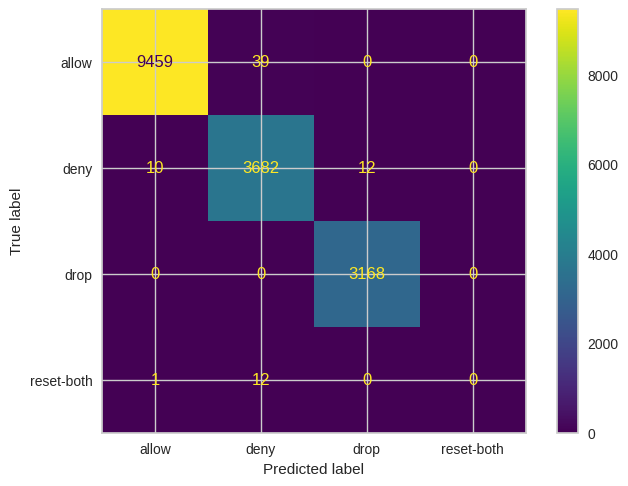

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,p)

In [ ]:
rbf = svm.SVC(kernel='rbf', gamma=1, C=0.005).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
p=rbf.predict(X_test)
print(classification_report(y_test,p))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,p)